In [1]:
import sys
import pickle
import torch
print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['..//', '..\\'])
print("Torch version: %s" % torch.__version__)

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)] on win32
Torch version: 2.0.1+cu118


# Classification net

In [52]:
from torch.utils.data import Dataset
from torch import nn
import utils


output_size = 130


class EmbeddingDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, output_size)
        )

    def forward(self, data):
        res = self.net(data)
        return res


class MergeMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.codes = MLP()
        self.docs = MLP()
        self.requirement = MLP()
        self.readme = MLP()
        self.net = nn.Sequential(
            nn.Linear(output_size * 4, output_size)
        )

    def forward(self, data):
        codes = self.codes(data[:, :768])
        docs = self.docs(data[:, 768:768*2])
        requirement = self.requirement(data[:, 768*2:768*3])
        readme = self.readme(data[:, 768*3:])
        bigData = torch.cat([codes, docs, requirement, readme], dim=1)
        res = self.net(bigData)
        return res


def build_embedding_sets(filename, unique_labels=None):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    repo_names = list(data.keys())
    embedding_types = list(data[repo_names[0]].keys())[-5:]
    mean_embeddings = {}
    labels = []

    for embedding in embedding_types:
        mean_embeddings[embedding] = []

    for repo in repo_names:
        if unique_labels and data[repo]['topic'] not in unique_labels:
            continue
        labels.append(data[repo]['topic'])
        for embedding in embedding_types:
            mean_embeddings[embedding].append(utils.mean_embeddings(data[repo][embedding]))

    return mean_embeddings, labels

In [53]:
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'structure_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_embeddings, trainLabels = build_embedding_sets("..\\Dataset\\repo_info_train_embeddings_reduce.pkl")
test_embeddings, testLabels = build_embedding_sets("..\\Dataset\\repo_info_test_embeddings_reduce.pkl")
valid_embeddings, validLabels = build_embedding_sets("..\\Dataset\\repo_info_validation_embeddings_reduce.pkl")
unique_labels = {}
set_labels = trainLabels + testLabels + validLabels
for label in set_labels:
    if label not in unique_labels:
        unique_labels[label] = 1
    else:
        unique_labels[label] += 1

print(len(unique_labels))
print(unique_labels)
unique_labels = list(unique_labels.keys())
labels_encoder = LabelEncoder()
labels_encoder.fit(unique_labels)
train_labels = labels_encoder.transform(trainLabels)
test_labels = labels_encoder.transform(testLabels)
valid_labels = labels_encoder.transform(validLabels)

130
{'Admin Panels': 7, 'Mock': 6, 'Design Patterns': 3, 'Data Validation': 5, 'Image Processing': 11, 'Compatibility': 1, 'Files': 5, 'Shell': 1, 'Office': 8, 'CLI Enhancements': 6, 'Data Analysis': 4, 'Tagging': 1, 'Mail Servers': 2, 'Terminal Rendering': 5, 'Code Analysis': 5, 'HTTP Clients': 6, 'Caching': 4, 'Package Repositories': 3, 'Date and Time': 8, 'Framework agnostic': 6, 'Productivity CLI Tools': 9, 'Unique identifiers': 2, 'Downloader': 3, 'Environment Management': 2, 'HTML Manipulation': 6, 'Profiler': 5, 'Machine Learning': 6, 'Web Crawling': 6, 'Forms': 6, 'Miscellaneous': 5, 'Natural Language Processing': 8, 'Algorithms': 4, 'Serialization': 3, 'Third-party APIs': 6, 'Geolocation': 4, 'OAuth': 6, 'Permissions': 2, 'Asynchronous Clients': 1, 'Network Virtualization': 3, 'Database Drivers': 1, 'Relational Databases': 6, 'Web Content Extracting': 9, 'Task Queues': 4, 'Science': 7, 'JWT': 3, 'SSH-style Deployment': 3, 'Package Management': 3, 'Job Scheduler': 6, 'Slugify':

Training starting
Epoch: 20, train loss: 0.464, validation loss: 0.493, train acc: 0.130, validation acc: 0.019
7693.0 examples/sec on cuda total training time:0.4 sec
Epoch: 40, train loss: 0.442, validation loss: 0.490, train acc: 0.390, validation acc: 0.044
9918.0 examples/sec on cuda total training time:0.7 sec
Epoch: 60, train loss: 0.421, validation loss: 0.486, train acc: 0.500, validation acc: 0.060
9112.1 examples/sec on cuda total training time:0.9 sec
Epoch: 80, train loss: 0.399, validation loss: 0.483, train acc: 0.570, validation acc: 0.083
9091.2 examples/sec on cuda total training time:1.1 sec
Epoch: 100, train loss: 0.377, validation loss: 0.480, train acc: 0.590, validation acc: 0.095
8346.4 examples/sec on cuda total training time:1.3 sec
Epoch: 120, train loss: 0.355, validation loss: 0.479, train acc: 0.590, validation acc: 0.102
8317.9 examples/sec on cuda total training time:1.6 sec
Epoch: 140, train loss: 0.333, validation loss: 0.477, train acc: 0.600, validat

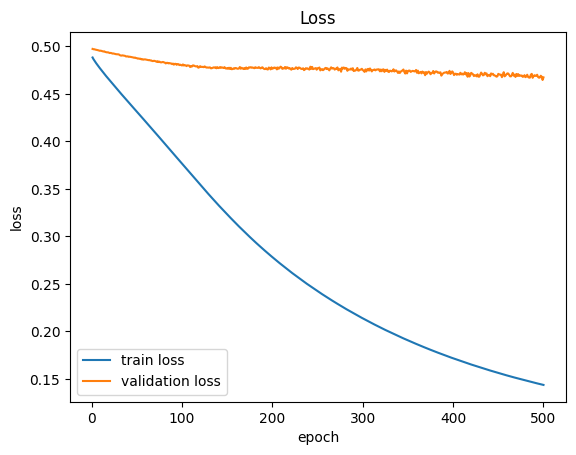

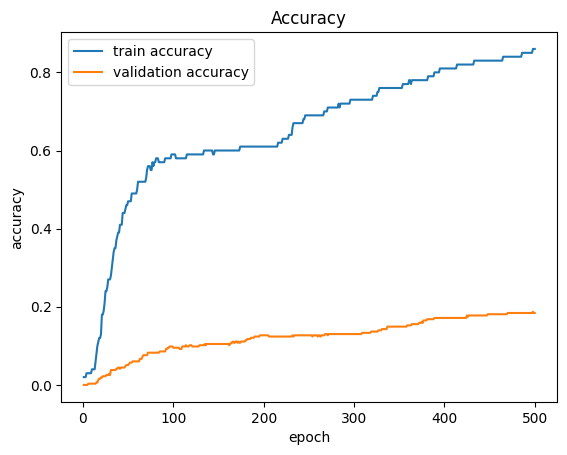

codes_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.465, validation loss: 0.490, train acc: 0.080, validation acc: 0.019
9088.8 examples/sec on cuda total training time:0.2 sec
Epoch: 40, train loss: 0.444, validation loss: 0.487, train acc: 0.440, validation acc: 0.048
9999.1 examples/sec on cuda total training time:0.5 sec
Epoch: 60, train loss: 0.423, validation loss: 0.484, train acc: 0.550, validation acc: 0.073
7689.3 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.402, validation loss: 0.483, train acc: 0.600, validation acc: 0.073
5555.1 examples/sec on cuda total training time:1.0 sec
Epoch: 100, train loss: 0.382, validation loss: 0.479, train acc: 0.650, validation acc: 0.076
7692.6 examples/sec on cuda total training time:1.2 sec
Epoch: 120, train loss: 0.362, validation loss: 0.477, train acc: 0.680, validation acc: 0.079
8536.5 examples/sec on cuda total training time:1.4 sec
Epoch: 140, train loss: 0.342, v

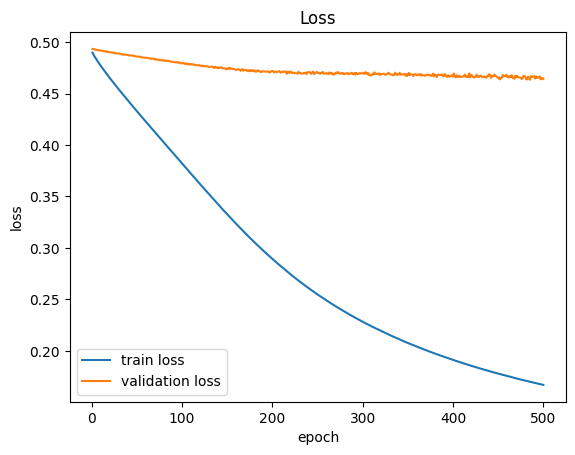

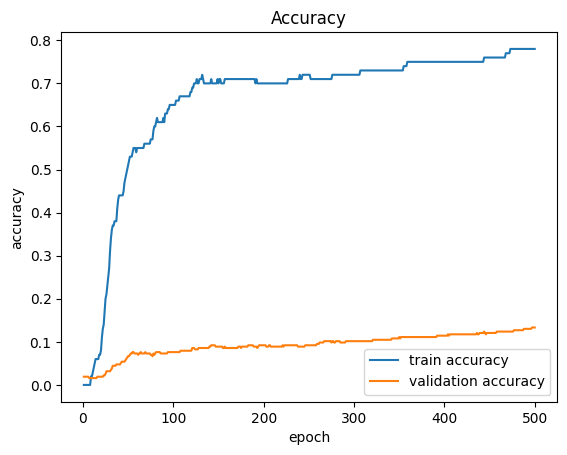

docs_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.477, validation loss: 0.496, train acc: 0.030, validation acc: 0.013
8300.9 examples/sec on cuda total training time:0.2 sec
Epoch: 40, train loss: 0.467, validation loss: 0.496, train acc: 0.060, validation acc: 0.010
7621.8 examples/sec on cuda total training time:0.5 sec
Epoch: 60, train loss: 0.456, validation loss: 0.497, train acc: 0.070, validation acc: 0.006
8333.8 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.446, validation loss: 0.498, train acc: 0.090, validation acc: 0.000
10000.5 examples/sec on cuda total training time:0.9 sec
Epoch: 100, train loss: 0.435, validation loss: 0.500, train acc: 0.100, validation acc: 0.013
11110.7 examples/sec on cuda total training time:1.2 sec
Epoch: 120, train loss: 0.426, validation loss: 0.504, train acc: 0.100, validation acc: 0.013
7691.3 examples/sec on cuda total training time:1.4 sec
Epoch: 140, train loss: 0.418, 

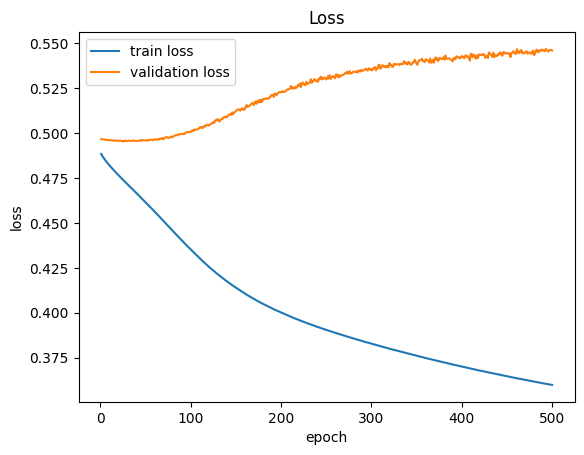

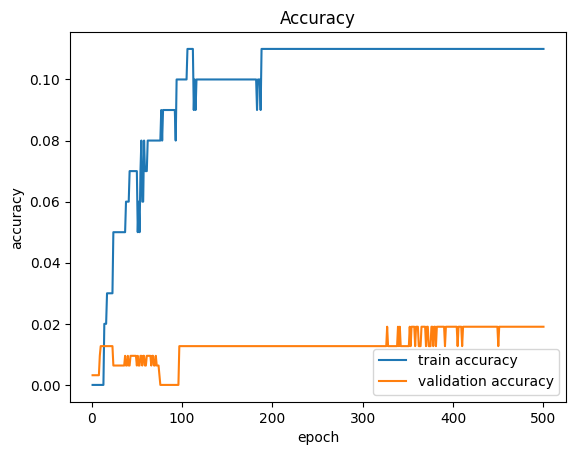

structure_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.472, validation loss: 0.494, train acc: 0.100, validation acc: 0.022
11004.6 examples/sec on cuda total training time:0.2 sec
Epoch: 40, train loss: 0.457, validation loss: 0.493, train acc: 0.230, validation acc: 0.016
8333.9 examples/sec on cuda total training time:0.4 sec
Epoch: 60, train loss: 0.442, validation loss: 0.494, train acc: 0.230, validation acc: 0.010
9101.2 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.427, validation loss: 0.495, train acc: 0.250, validation acc: 0.013
10004.3 examples/sec on cuda total training time:0.9 sec
Epoch: 100, train loss: 0.412, validation loss: 0.497, train acc: 0.220, validation acc: 0.013
9990.0 examples/sec on cuda total training time:1.1 sec
Epoch: 120, train loss: 0.398, validation loss: 0.501, train acc: 0.260, validation acc: 0.016
9896.9 examples/sec on cuda total training time:1.3 sec
Epoch: 140, train loss: 0.

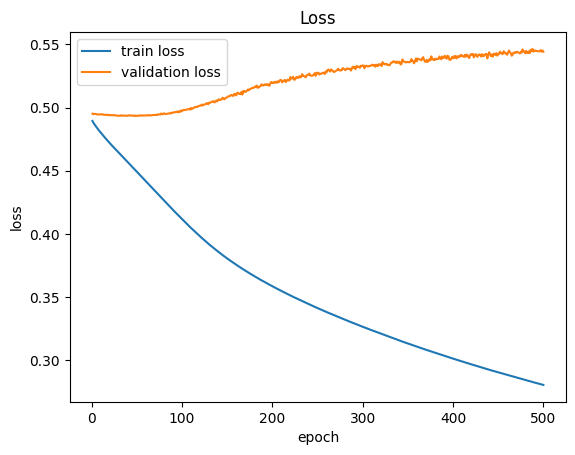

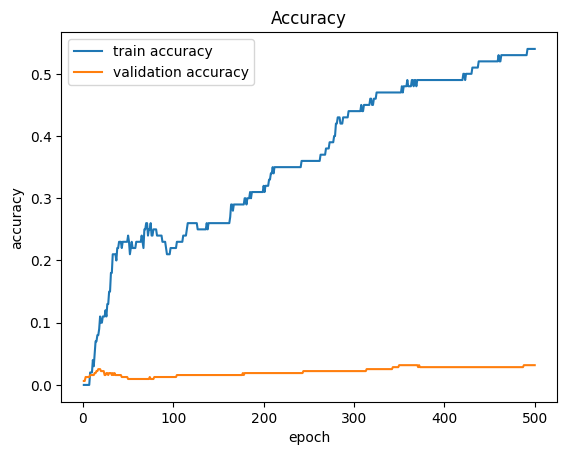

requirements_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.440, validation loss: 0.496, train acc: 0.190, validation acc: 0.013
7692.6 examples/sec on cuda total training time:0.3 sec
Epoch: 40, train loss: 0.394, validation loss: 0.492, train acc: 0.510, validation acc: 0.029
11215.9 examples/sec on cuda total training time:0.5 sec
Epoch: 60, train loss: 0.351, validation loss: 0.490, train acc: 0.680, validation acc: 0.029
9090.6 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.310, validation loss: 0.488, train acc: 0.760, validation acc: 0.051
9090.4 examples/sec on cuda total training time:0.9 sec
Epoch: 100, train loss: 0.272, validation loss: 0.488, train acc: 0.770, validation acc: 0.054
9091.8 examples/sec on cuda total training time:1.2 sec
Epoch: 120, train loss: 0.238, validation loss: 0.488, train acc: 0.840, validation acc: 0.063
9047.1 examples/sec on cuda total training time:1.4 sec
Epoch: 140, train loss: 

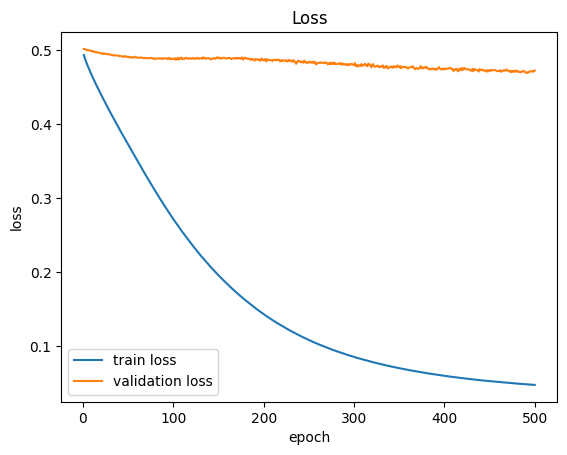

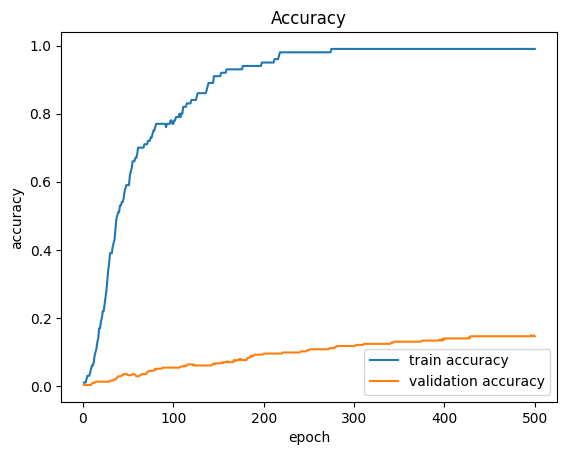

readme_embeddings
------------------------------


In [57]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 10
epochs = 500
lr = 0.00001
weight_decay = 0.1


for embedding_name in embedding_types:
    train_embedding = train_embeddings[embedding_name]
    valid_embedding = valid_embeddings[embedding_name]
    train_dataset = EmbeddingDataset(train_embedding, train_labels)
    valid_dataset = EmbeddingDataset(valid_embedding, valid_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    net = MLP()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
    train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, valid_loader, train_loader, log_num=20, init=False)
    drawGraph(train_loss, test_loss, train_acc, test_acc)
    print(embedding_name)
    print("-"*30)

torch.Size([315, 3072])
torch.Size([100, 3072])
Training starting
Epoch: 20, train loss: 0.037, validation loss: 0.468, train acc: 1.000, validation acc: 0.130
4545.1 examples/sec on cuda total training time:0.7 sec
Epoch: 40, train loss: 0.035, validation loss: 0.460, train acc: 1.000, validation acc: 0.149
4446.3 examples/sec on cuda total training time:1.2 sec
Epoch: 60, train loss: 0.038, validation loss: 0.465, train acc: 1.000, validation acc: 0.171
4545.4 examples/sec on cuda total training time:1.6 sec
Epoch: 80, train loss: 0.041, validation loss: 0.472, train acc: 1.000, validation acc: 0.165
4764.8 examples/sec on cuda total training time:2.0 sec
Epoch: 100, train loss: 0.043, validation loss: 0.479, train acc: 1.000, validation acc: 0.165
4541.8 examples/sec on cuda total training time:2.5 sec
Epoch: 120, train loss: 0.043, validation loss: 0.486, train acc: 1.000, validation acc: 0.149
4764.9 examples/sec on cuda total training time:2.9 sec
Epoch: 140, train loss: 0.042, v

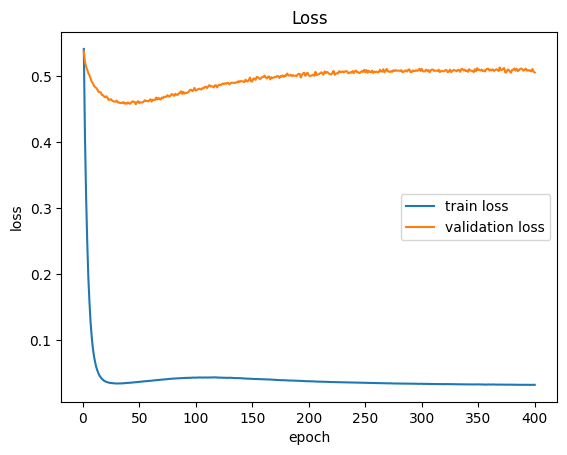

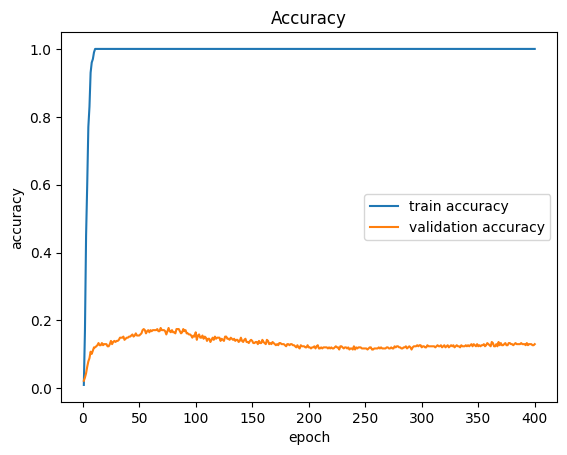

In [58]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 10
epochs = 400
lr = 0.0001
weight_decay = 0.1

train_embedding_list = []
valid_embedding_list = []
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
for embedding_name in embedding_types:
    train_embedding_list.append(torch.stack(train_embeddings[embedding_name], dim=0))
    valid_embedding_list.append(torch.stack(valid_embeddings[embedding_name], dim=0))

train_embedding = torch.cat(train_embedding_list, dim=1)
valid_embedding = torch.cat(valid_embedding_list, dim=1)
print(train_embedding.shape)
print(valid_embedding.shape)

train_dataset = EmbeddingDataset(train_embedding, train_labels)
valid_dataset = EmbeddingDataset(valid_embedding, valid_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

net = MergeMLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, valid_loader, train_loader, log_num=20)
drawGraph(train_loss, test_loss, train_acc, test_acc)

# Biclassification net

In [24]:
import random
from torch.utils.data import Dataset
from torch import nn
import utils


def build_embedding_sets(filename, unique_labels=None):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    repo_names = list(data.keys())
    embedding_types = list(data[repo_names[0]].keys())[-5:]
    mean_embeddings = {}
    labels = []

    for embedding in embedding_types:
        mean_embeddings[embedding] = []

    for repo in repo_names:
        if unique_labels and data[repo]['topic'] not in unique_labels:
            continue
        labels.append(data[repo]['topic'])
        for embedding in embedding_types:
            mean_embeddings[embedding].append(utils.mean_embeddings(data[repo][embedding]))

    return mean_embeddings, labels

class PairDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return torch.cat(self.data[index], dim=0), self.labels[index]


class SingleEmbeddingClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 300)
        )
        self.classifier = nn.Sequential(
            nn.Linear(300 * 2, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, 2),
        )

    def forward(self, data):
        e1 = data[:, :768]
        e2 = data[:, 768:]
        res1 = self.net(e1)
        res2 = self.net(e2)
        res = torch.cat([res1,res2], dim=1)
        res = self.classifier(res)
        return res


def mergeEmbedding(sets_list, labels_list, embedding_types):
    all_embeddings_set = {}
    all_labels = []
    for t in embedding_types:
        all_embeddings_set[t] = []

    for embedding_set in sets_list:
        for t in embedding_types:
            all_embeddings_set[t] = all_embeddings_set[t] + embedding_set[t]
    for labels_set in labels_list:
        all_labels = all_labels + labels_set

    return all_embeddings_set, all_labels



def build_pair_data(data, labels, embedding_types, balanced=1.0):
    pair_embeddings = {}
    pair_labels = []
    for embedding_type in embedding_types:
        pair_embeddings[embedding_type] = []

    for i in range(len(labels)):
        for j in range(i, len(labels)):
            if labels[i] != labels[j]:
                pair_labels.append(0)
            else:
                pair_labels.append(1)

            for embedding_type in embedding_types:
                e1 = data[embedding_type][i]
                e2 = data[embedding_type][j]
                pair_embeddings[embedding_type].append((e1, e2))

    if balanced:
        print("Before balanced:", len(pair_labels))
        c0_index = []
        c1_index = []
        for i in range(len(pair_labels)):
            if pair_labels[i] == 0:
                c0_index.append(i)
            else:
                c1_index.append(i)

        c0_num = len(c0_index)
        c1_num = len(c1_index)
        if c0_num > c1_num:
            c0_num = min(int(c1_num * balanced), c0_num)
            c0_index = random.sample(c0_index, c0_num)
        else:
            c1_num = min(int(c0_num * balanced), c1_num)
            c1_index = random.sample(c1_index, c1_num)

        print("C 0:", c0_num)
        print("C 1:", c1_num)

        balanced_index = c0_index + c1_index

        balanced_embeddings = {}
        balanced_labels = []
        for embedding_type in embedding_types:
            balanced_embeddings[embedding_type] = []


        for i in balanced_index:
            balanced_labels.append(pair_labels[i])
            for embedding_type in embedding_types:
                balanced_embeddings[embedding_type].append(pair_embeddings[embedding_type][i])

        pair_embeddings = balanced_embeddings
        pair_labels = balanced_labels
        print("After balanced:", len(pair_labels))

    return pair_embeddings, pair_labels


def split_pair_embeddings(pair_embeddings, pair_labels, train_test_ratio=0.8):
    half_index = len(pair_labels)//2
    split_index = int(train_test_ratio * half_index)
    train_pairs = {}
    valid_pairs = {}
    train_labels = pair_labels[:split_index] + pair_labels[half_index:half_index + split_index]
    valid_labels = pair_labels[split_index:half_index] + pair_labels[half_index + split_index:]
    for t in list(pair_embeddings.keys()):
        train_pairs[t] = pair_embeddings[t][:split_index] + pair_embeddings[t][half_index:half_index + split_index]
        valid_pairs[t] = pair_embeddings[t][split_index:half_index] + pair_embeddings[t][half_index + split_index:]
    print("Train set size:", len(train_labels))
    print("Validation set size:", len(valid_labels))
    return train_pairs, valid_pairs, train_labels, valid_labels

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'structure_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_embeddings, trainLabels = build_embedding_sets("..\\Dataset\\repo_info_train_embeddings_reduce.pkl")
test_embeddings, testLabels = build_embedding_sets("..\\Dataset\\repo_info_test_embeddings_reduce.pkl")
valid_embeddings, validLabels = build_embedding_sets("..\\Dataset\\repo_info_validation_embeddings_reduce.pkl")

train_pair_embeddings, train_labels = build_pair_data(train_embeddings, trainLabels, embedding_types, balanced=1)
test_pair_embeddings, test_labels = build_pair_data(test_embeddings, testLabels, embedding_types, balanced=1)
valid_pair_embeddings, valid_labels = build_pair_data(valid_embeddings, validLabels, embedding_types, balanced=1)

all_embeddings, allLabels = mergeEmbedding([train_embeddings, test_embeddings, valid_embeddings], [trainLabels, testLabels, validLabels], embedding_types)
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=1)
num_items = len(all_labels)
split_index = int(num_items * 0.8)
train_pair_embeddings, valid_pair_embeddings, train_labels, valid_labels = split_pair_embeddings(all_pair_embeddings, all_labels)

Before balanced: 49770
C 0: 744
C 1: 744
After balanced: 1488
Before balanced: 861
C 0: 50
C 1: 50
After balanced: 100
Before balanced: 5050
C 0: 146
C 1: 146
After balanced: 292
Before balanced: 104196
C 0: 1349
C 1: 1349
After balanced: 2698
Train set size: 2158
Validation set size: 540


cuda
Training starting
Epoch: 20, train loss: 0.008, validation loss: 0.012, train acc: 0.760, validation acc: 0.613
21138.5 examples/sec on cuda total training time:2.3 sec
Epoch: 40, train loss: 0.006, validation loss: 0.011, train acc: 0.879, validation acc: 0.665
23185.8 examples/sec on cuda total training time:4.2 sec
Epoch: 60, train loss: 0.005, validation loss: 0.010, train acc: 0.924, validation acc: 0.681
23662.1 examples/sec on cuda total training time:6.1 sec
Epoch: 80, train loss: 0.004, validation loss: 0.010, train acc: 0.958, validation acc: 0.706
20630.6 examples/sec on cuda total training time:7.9 sec
Epoch: 100, train loss: 0.004, validation loss: 0.010, train acc: 0.973, validation acc: 0.713
18170.1 examples/sec on cuda total training time:10.0 sec
Epoch: 120, train loss: 0.003, validation loss: 0.010, train acc: 0.989, validation acc: 0.733
23325.9 examples/sec on cuda total training time:12.0 sec
Epoch: 140, train loss: 0.003, validation loss: 0.010, train acc: 0

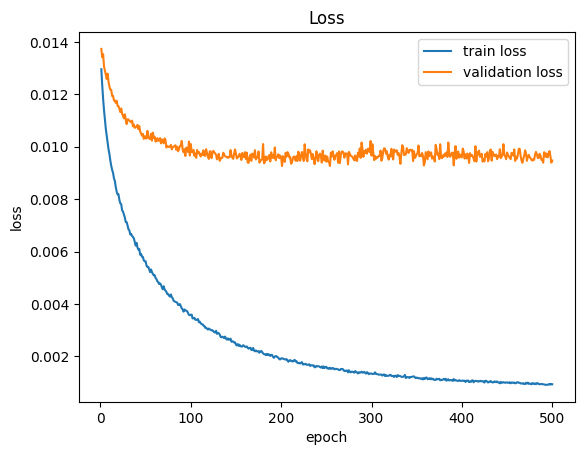

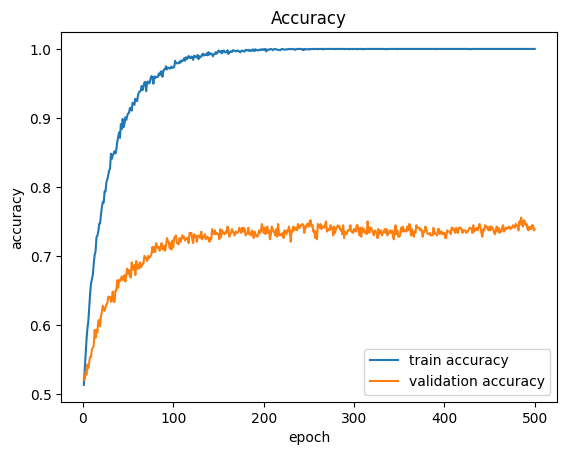

codes_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.009, validation loss: 0.012, train acc: 0.682, validation acc: 0.574
25174.8 examples/sec on cuda total training time:1.9 sec
Epoch: 40, train loss: 0.007, validation loss: 0.012, train acc: 0.792, validation acc: 0.602
23498.9 examples/sec on cuda total training time:3.7 sec
Epoch: 60, train loss: 0.006, validation loss: 0.012, train acc: 0.868, validation acc: 0.626
23734.7 examples/sec on cuda total training time:5.6 sec
Epoch: 80, train loss: 0.005, validation loss: 0.011, train acc: 0.915, validation acc: 0.654
24180.7 examples/sec on cuda total training time:7.4 sec
Epoch: 100, train loss: 0.004, validation loss: 0.011, train acc: 0.946, validation acc: 0.665
22037.4 examples/sec on cuda total training time:9.3 sec
Epoch: 120, train loss: 0.004, validation loss: 0.011, train acc: 0.962, validation acc: 0.661
25145.0 examples/sec on cuda total training time:11.2 sec
Epoch: 140, train loss: 0

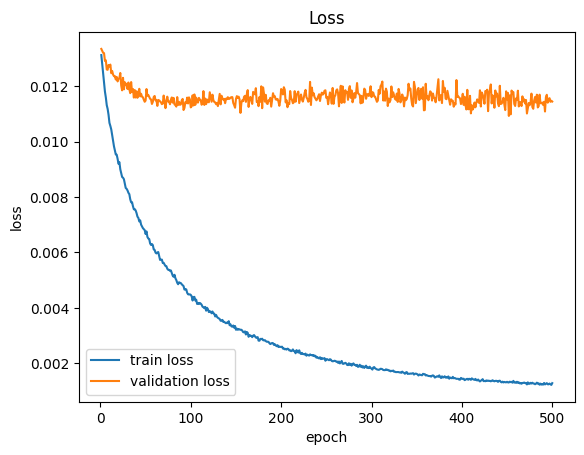

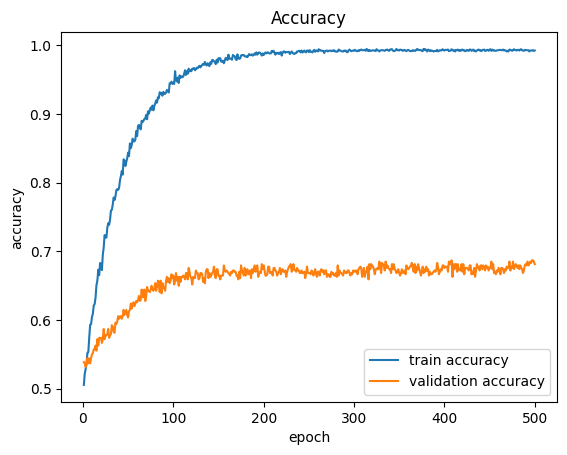

docs_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.010, validation loss: 0.017, train acc: 0.628, validation acc: 0.465
18790.9 examples/sec on cuda total training time:2.3 sec
Epoch: 40, train loss: 0.010, validation loss: 0.017, train acc: 0.637, validation acc: 0.420
17975.1 examples/sec on cuda total training time:4.7 sec
Epoch: 60, train loss: 0.010, validation loss: 0.018, train acc: 0.632, validation acc: 0.470
18202.1 examples/sec on cuda total training time:7.0 sec
Epoch: 80, train loss: 0.010, validation loss: 0.018, train acc: 0.643, validation acc: 0.411
24245.7 examples/sec on cuda total training time:9.1 sec
Epoch: 100, train loss: 0.010, validation loss: 0.018, train acc: 0.633, validation acc: 0.441
23641.2 examples/sec on cuda total training time:10.9 sec
Epoch: 120, train loss: 0.010, validation loss: 0.018, train acc: 0.641, validation acc: 0.441
23532.5 examples/sec on cuda total training time:12.8 sec
Epoch: 140, train loss: 0

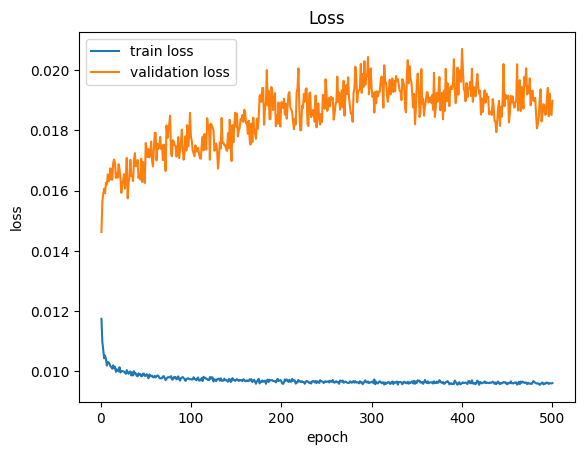

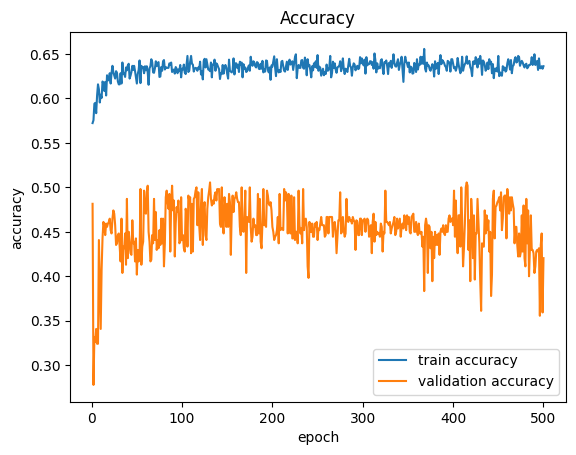

structure_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.010, validation loss: 0.013, train acc: 0.681, validation acc: 0.559
18359.6 examples/sec on cuda total training time:2.2 sec
Epoch: 40, train loss: 0.008, validation loss: 0.013, train acc: 0.783, validation acc: 0.581
17895.7 examples/sec on cuda total training time:4.5 sec
Epoch: 60, train loss: 0.007, validation loss: 0.013, train acc: 0.853, validation acc: 0.593
19648.9 examples/sec on cuda total training time:6.6 sec
Epoch: 80, train loss: 0.006, validation loss: 0.013, train acc: 0.892, validation acc: 0.598
20006.4 examples/sec on cuda total training time:8.9 sec
Epoch: 100, train loss: 0.005, validation loss: 0.013, train acc: 0.923, validation acc: 0.600
18954.9 examples/sec on cuda total training time:11.2 sec
Epoch: 120, train loss: 0.004, validation loss: 0.014, train acc: 0.941, validation acc: 0.596
19336.6 examples/sec on cuda total training time:13.5 sec
Epoch: 140, train lo

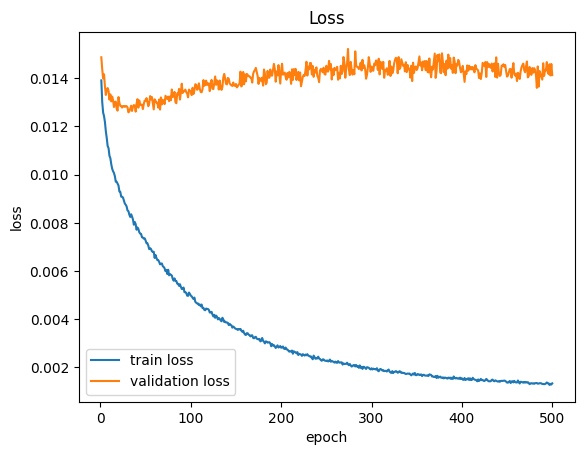

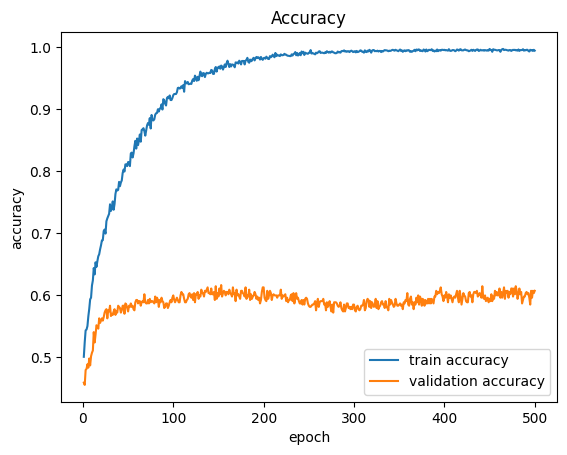

requirements_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.010, validation loss: 0.015, train acc: 0.640, validation acc: 0.487
22995.9 examples/sec on cuda total training time:1.9 sec
Epoch: 40, train loss: 0.008, validation loss: 0.014, train acc: 0.763, validation acc: 0.496
23712.6 examples/sec on cuda total training time:3.8 sec
Epoch: 60, train loss: 0.006, validation loss: 0.015, train acc: 0.861, validation acc: 0.494
23277.8 examples/sec on cuda total training time:5.6 sec
Epoch: 80, train loss: 0.005, validation loss: 0.015, train acc: 0.921, validation acc: 0.509
23489.9 examples/sec on cuda total training time:7.5 sec
Epoch: 100, train loss: 0.005, validation loss: 0.015, train acc: 0.956, validation acc: 0.494
18003.1 examples/sec on cuda total training time:9.4 sec
Epoch: 120, train loss: 0.004, validation loss: 0.015, train acc: 0.980, validation acc: 0.502
19294.0 examples/sec on cuda total training time:11.5 sec
Epoch: 140, train 

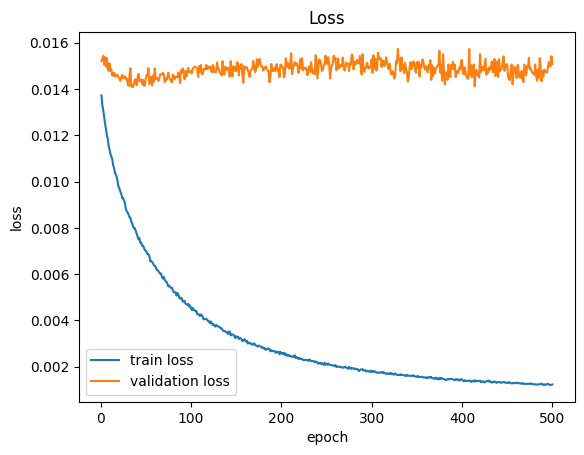

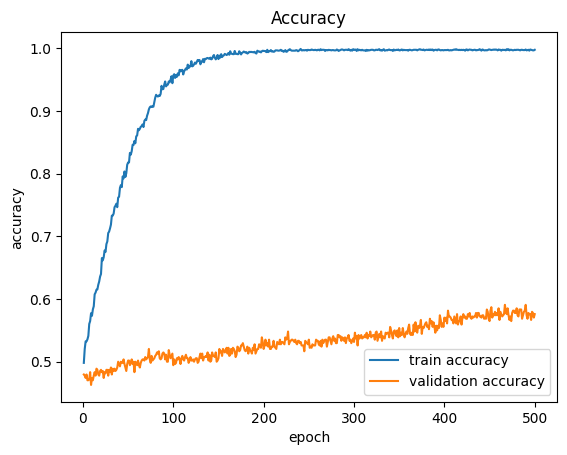

readme_embeddings
------------------------------


In [25]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 64
epochs = 500
lr = 0.00001
weight_decay = 0.1

print(device)
for embedding_name in embedding_types:
    train_embedding = train_pair_embeddings[embedding_name]
    valid_embedding = valid_pair_embeddings[embedding_name]
    train_dataset = PairDataset(train_embedding, train_labels)
    valid_dataset = PairDataset(valid_embedding, valid_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    net = SingleEmbeddingClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
    train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, train_loader, valid_loader, log_num=20, save_best=True, save_dir=embedding_name)
    drawGraph(train_loss, test_loss, train_acc, test_acc)
    print(embedding_name)
    print("-"*30)

In [49]:
class MergePairDataset(Dataset):
    def __init__(self, data, labels, embedding_types):
        self.data = []
        for i in range(len(labels)):
            e1 = []
            e2 = []
            for t in embedding_types:
                e1.append(data[t][i][0])
                e2.append(data[t][i][1])
            row = torch.cat(e1+e2, dim=0)
            self.data.append(row)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


class EmbeddingMLP(nn.Module):
    def __init__(self, size=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768 * size, 900 * size),
            nn.BatchNorm1d(900 * size),
            nn.ReLU(),
            nn.Linear(900 * size, 300 * size)
        )

    def forward(self, data):
        res = self.net(data)
        return res


class PairClassifier(nn.Module):
    def __init__(self, size=4):
        super().__init__()
        self.encoder = EmbeddingMLP(size)
        self.net = nn.Sequential(
            nn.Linear(300 * size * 2, 3000),
            nn.ReLU(),
            nn.Linear(3000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2),
        )

    def forward(self, data):
        e1 = self.encoder(data[:, :768 * 4])
        e2 = self.encoder(data[:, 768 * 4:])
        twins = torch.cat([e1, e2], dim=1)
        res = self.net(twins)
        return res

cuda
Training starting
Epoch: 20, train loss: 0.005, validation loss: 0.012, train acc: 0.945, validation acc: 0.544
6190.1 examples/sec on cuda total training time:7.5 sec
Epoch: 40, train loss: 0.004, validation loss: 0.011, train acc: 0.974, validation acc: 0.609
6744.1 examples/sec on cuda total training time:14.1 sec
Epoch: 60, train loss: 0.003, validation loss: 0.010, train acc: 0.983, validation acc: 0.663
6511.9 examples/sec on cuda total training time:20.7 sec
Epoch: 80, train loss: 0.002, validation loss: 0.009, train acc: 0.987, validation acc: 0.700
6043.2 examples/sec on cuda total training time:27.6 sec
Epoch: 100, train loss: 0.002, validation loss: 0.008, train acc: 0.990, validation acc: 0.731
6532.4 examples/sec on cuda total training time:34.3 sec
Epoch: 120, train loss: 0.002, validation loss: 0.008, train acc: 0.994, validation acc: 0.778
6661.1 examples/sec on cuda total training time:40.8 sec
Epoch: 140, train loss: 0.001, validation loss: 0.007, train acc: 0.99

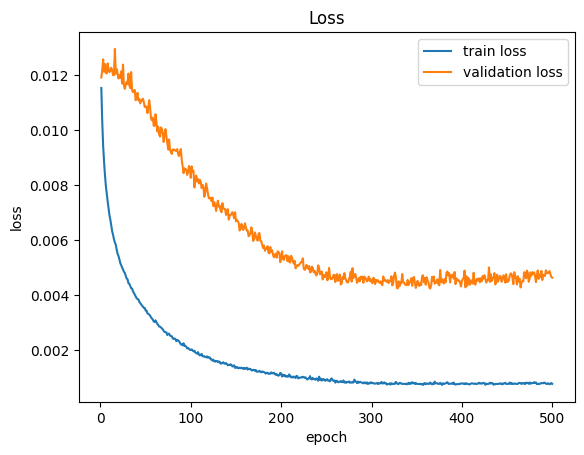

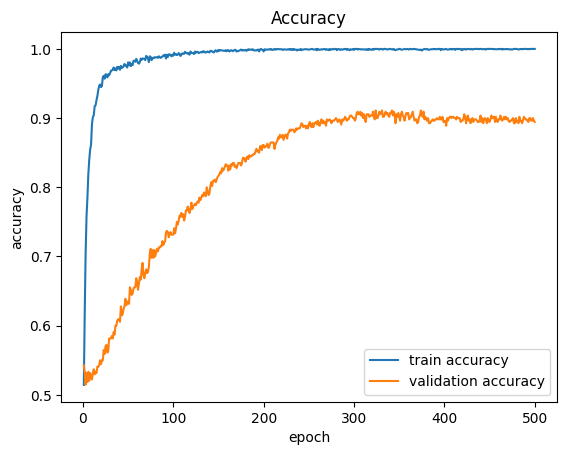

In [51]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 64
epochs = 500
lr = 0.00001
weight_decay = 0.1

print(device)
train_embedding = train_pair_embeddings
valid_embedding = valid_pair_embeddings
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_dataset = MergePairDataset(train_embedding, train_labels, embedding_types)
valid_dataset = MergePairDataset(valid_embedding, valid_labels, embedding_types)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
net = PairClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, train_loader, valid_loader, log_num=20, save_best=True, save_dir="TWINS_MODEL")
drawGraph(train_loss, test_loss, train_acc, test_acc)